## Cuda Memory Management
https://pytorch.org/docs/stable/cuda.html#module-torch.cuda

In [1]:
import torch

# Define the execution device
# cuda check
device = 'cuda' if torch.cuda.is_available() else 'cpu'
print("The model will be running on", device, "device")

The model will be running on cuda device


#### 현재 할당 된 메모리 상태 확인

In [2]:
torch.cuda.memory_summary(abbreviated=True)
# torch.cuda.memory_stats()

'|===========================================================================|\n|                  PyTorch CUDA memory summary, device ID 0                 |\n|---------------------------------------------------------------------------|\n|            CUDA OOMs: 0            |        cudaMalloc retries: 0         |\n|===========================================================================|\n|        Metric         | Cur Usage  | Peak Usage | Tot Alloc  | Tot Freed  |\n|---------------------------------------------------------------------------|\n| Allocated memory      |       0 B  |       0 B  |       0 B  |       0 B  |\n|---------------------------------------------------------------------------|\n| Active memory         |       0 B  |       0 B  |       0 B  |       0 B  |\n|---------------------------------------------------------------------------|\n| GPU reserved memory   |       0 B  |       0 B  |       0 B  |       0 B  |\n|--------------------------------------------------

In [3]:
print("(the global free GPU memory, total GPU memory):", torch.cuda.mem_get_info())

(the global free GPU memory, total GPU memory): (3050045440, 4093181952)


In [4]:
print(torch.cuda.list_gpu_processes())
print("the current GPU memory occupied by tensors : ", torch.cuda.memory_allocated())
print("the current GPU memory managed by the caching allocator : ", torch.cuda.memory_reserved())

GPU:0
process       4571 uses      411.000 MB GPU memory
the current GPU memory occupied by tensors :  0
the current GPU memory managed by the caching allocator :  0


In [5]:
torch.cuda.empty_cache()
# 실행 후, jupyter lab 재실행

In [26]:
# torch.cuda.set_per_process_memory_fraction(0.9)

In [28]:
# Deletes memory allocated using the CUDA memory allocator.
# torch.cuda.caching_allocator_delete('GPU:0')

SystemError: <built-in function _cuda_cudaCachingAllocator_raw_delete> returned a result with an error set

## Intel Scene Dataset

#### using timm

In [24]:
from timm.data.transforms_factory import create_transform
from timm.data import create_dataset

# create_dataset reads "train" folder and "val" folder.
# the folder name must be matched.
myds = create_dataset(name='', root = '/media/nd-ygr/Data/Image/SceneImage_Intel/sceneimages.tar', transform=create_transform(500), split='train')

image, label = myds[0]
image.shape

torch.Size([3, 500, 500])

In [25]:
import torchvision.transforms as T
from PIL import Image

transform = T.ToPILImage()
imgview = transform(image)
imgview.show()

In [26]:
myds, type(myds)

(<timm.data.dataset.ImageDataset at 0x7fb39b5e9d30>,
 timm.data.dataset.ImageDataset)

#### define image dataset

In [2]:
# Define Batch Size
batch_size = 10
number_of_labels = 6
img_size = 300

# Define Classes
classes = ('buildings', 'forest', 'glacier', 'mountain', 'sea', 'street')

In [3]:
from glob import glob

# Dataset Path List
path = "/media/nd-ygr/storage/Data/Image/Intel_Scene/"

trainset_path = glob(f'{path}/train/*/*.jpg')
valset_path = glob(f'{path}/val/*/*.jpg')
predset_path = glob(f'{path}/test/*.jpg')

print(len(trainset_path))    #14034
print(len(valset_path))      # 3000
print(len(predset_path))     # 7301

14034
3000
7301


In [4]:
import matplotlib.pyplot as plt
import numpy as np

def imshow(image):
    
    image = image / 2 + 0.5
    npimage = image.numpy()
    plt.imshow(np.transpose(npimage, (1,2,0)))
    plt.show()

## Define Loading and Transforming function 

In [5]:
# trainset_path[0]
# '/media/nd-ygr/Data/Image/SceneImage_Intel/train/buildings/1291.jpg'

def get_label(label_path_list):
    labels = []
    for label_path in label_path_list:
        label = label_path.split("/")[-2]
        labels.append(label)
        
    return labels

In [6]:
import torch
from PIL import Image
from torch.utils.data import Dataset

class MyDataset(Dataset):
    
    """
    image_list : 이미지 경로 리스트
    label_list : 이미지 레이블 리스트
    transform = 전처리
    """
    
    def __init__(self, image_list, classes, transform):
        self.image_list = image_list
        self.label_list = get_label(image_list)
        self.classes = classes
        self.transform = transform
        
    def __len__(self):
        return len(self.image_list)
    
    def __getitem__(self, index):
        label = self.label_list[index]
        image_path = self.image_list[index]
        image = Image.open(image_path)
        if self.transform is not None:
            transformed_image = self.transform(image)
        
        return transformed_image, self.classes.index(label)

In [7]:
from torchvision import transforms

# transforms.RandomRotation((-180,180), transforms.InterpolationMode.BILINEAR, expand=True),

class MyTransform():
    
    def __init__(self, size):
        self.image_transform = transforms.Compose(
            [transforms.Resize((size,size), transforms.InterpolationMode.BICUBIC),
             transforms.ToTensor(),
             transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])
        
    def __call__(self, image):
        
        return self.image_transform(image)

In [8]:
from torch.utils.data import DataLoader

trainloader = DataLoader(MyDataset(trainset_path, classes, MyTransform(img_size)), batch_size=batch_size, shuffle=True)
print("The number of images in a training set : ", len(trainloader)*batch_size)

valloader = DataLoader(MyDataset(valset_path, classes, MyTransform(img_size)), batch_size=batch_size, shuffle=True)
print(f"The number of images in a validation set : {len(valloader)*batch_size}")

# testloader = 

The number of images in a training set :  14040
The number of images in a validation set : 3000


## Load classification model

In [9]:
import timm

model = timm.create_model('resnet50d', pretrained = True, num_classes = len(classes))  # global_pool = 'catavgmax'

In [10]:
# fc layer 없는 상태
print("model.get_classifier() : ", model.get_classifier())
num_in_features = model.get_classifier().in_features; num_in_features

model.get_classifier() :  Linear(in_features=2048, out_features=6, bias=True)


2048

In [11]:
import torch
from torch import nn

dropout = 0.5

model.fc = nn.Sequential(
    nn.BatchNorm1d(num_in_features),
    nn.Linear(in_features = num_in_features, out_features = 512, bias = True),
    nn.ReLU(),
    nn.BatchNorm1d(512),
    nn.Dropout(dropout),
    nn.Linear(in_features = 512, out_features = 6, bias = True))

In [18]:
import torch
from torch import nn

dropout = 0.4

model.fc = nn.Sequential(
    nn.BatchNorm1d(num_in_features),
    nn.Linear(in_features = num_in_features, out_features = 1028, bias = True),
    nn.ReLU(),
    nn.BatchNorm1d(1028),
    nn.Linear(in_features = 1028, out_features = 512, bias = True),
    nn.ReLU(),
    nn.Dropout(dropout),
    nn.Linear(in_features = 512, out_features = 6, bias = True))

In [19]:
# 모델의 마지막 레이어에 커스텀 레이어가 적용된 모습을 볼 수 있다.
model.eval()

ResNet(
  (conv1): Sequential(
    (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
    (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (4): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): ReLU(inplace=True)
    (6): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
  )
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (act1): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (act1): ReLU(inplace=True)
      (conv2): Co

## Define Validation Evaluator

In [11]:
# MS-vision-evaluation 사용
# https://github.com/microsoft/vision-evaluation
from vision_evaluation.evaluators import TopKAccuracyEvaluator as topkeval

def validation(model):
    
    total = 0
    accuracy = 0
    
    with torch.no_grad():
        for images, labels in valloader:
            
            # images = images.to(device)
            # labels = labels.to(device)
            
            outputs = model(images)
            
            topkmodel = topkeval(1)
            # print(topkmodel)
            
            topk = topkmodel.add_predictions(outputs, labels)
            # print(topk)
            
            topk = topkmodel.get_report()
            # print(topk)
            
            topk = list(topk.values())[0]
            
            total += 1
            accuracy += topk
            
#             _, predicted = torch.max(outputs, 1)
            
#             total += labels.size(0)
#             accuracy += (predicted == labels).sum().item()
            
#         accuracy = (100 * accuracy) / total
        
    # return accuracy 
    
        topk_average = topk/total
        
    return topk_average*100

In [12]:
import torchvision

def validation(model):
    
    total = 0.0
    accuracy = 0.0
    i = 0

    
    with torch.no_grad():
        
        for images, labels in valloader:
            
            if i == 0 :
                imshow(torchvision.utils.make_grid(images))
            
            images = images.to(device)
            labels = labels.to(device)
            
            outputs = model(images)
            
            values, predicted = torch.max(outputs, 1)
            
            total += labels.size(0)
            accuracy += (predicted == labels).sum().item()
            
            if i == 0:
                # print("images size : ", images.size(), end="\n\n")
                print("labels : ", labels, end="\n\n")
                print("values : ", values, end="\n\n")
                print("predicted label : ", predicted, end="\n\n")
                print("Accuracy : ", accuracy)

                i += 1
            
        accuracy = (100 * accuracy) / total

    return accuracy

## 1차 Training!

In [13]:
def saveModel(model):
    path = './timm_result/timm_sceneClassModel_4.pth'
    torch.save(model.state_dict(), path)

In [14]:
def train(model, num_epochs):
    
    import time
    
    # Convert model parameters and buffers to CPU or Cuda
    model = model.to(device)
    
    loss_fn = nn.CrossEntropyLoss()
    
    from torch.optim import Adam
    optimizer = Adam(model.parameters(), lr=0.0001, weight_decay=0.0001)
    
    best_accuracy = 0.0
    
    
    for epoch in range(num_epochs):
        
        start = time.time()
        
        running_loss = 0.0
        
        for i, (images, labels) in enumerate(trainloader, 0):
            
            images = images.to(device)
            labels = labels.to(device)
            
            optimizer.zero_grad()
            
            outputs = model(images)
            # print(type(outputs))
            # print(outputs)
            # print(outputs.data)
            # _, prediction = torch.max(outputs, 1)
            # print("prediction : ", prediction)
            
            loss = loss_fn(outputs, labels)
            
            # Caculate Gradients
            loss.backward()
            
            # Adjust parameters
            optimizer.step()
            
            running_loss += loss.item()
        
        
        val_accuracy = validation(model)
        print("[%3d / %3d] train loss : %.3f, validation accuracy : %.3f" % (epoch+1, num_epochs, running_loss/100, val_accuracy))
        
#         if divmod(epoch+1, 4)[1] == 0:
#             print("[%3d / %3d] train loss : %.3f, validation accuracy : %.3f" % (epoch+1, num_epochs, running_loss/100, val_accuracy))
            
        if val_accuracy > best_accuracy:
            saveModel(model)
            best_accuracy = val_accuracy
            print(" Saving model!!! \n")
            
        print(f"Duration (seconds) : {(time.time()-start)}")
        print(f"Duration (minutes) : {(time.time()-start)/60}")
        print(f"Duration (hours) : {(time.time()-start)/3600}")
        
            
#         topk_average = validation(model)
#         print(f"epoch {epoch+1} - validation Top1 Accuracy : {topk_average}")

    
#         if topk_average > best_accuracy:
#             saveModel(model)
#             best_accuracy = topk_average
#             print(" Saving model!!! ")


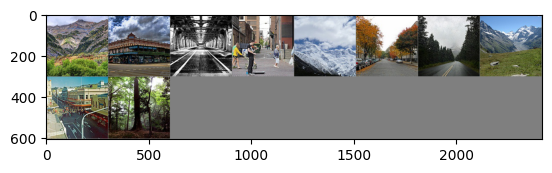

labels :  tensor([3, 0, 5, 5, 3, 5, 2, 2, 5, 1], device='cuda:0')

values :  tensor([ 4.9290,  6.2188,  3.2371,  4.6956,  5.7412,  4.0024,  1.4659,  6.2798,
         4.8561, 10.9240], device='cuda:0')

predicted label :  tensor([3, 0, 5, 5, 3, 5, 3, 2, 0, 1], device='cuda:0')

Accuracy :  8.0
[  1 /  20] train loss : 6.132, validation accuracy : 86.967
 Saving model!!! 

Duration (seconds) : 502.8968861103058
Duration (minutes) : 8.381614927450816
Duration (hours) : 0.13969358331627316


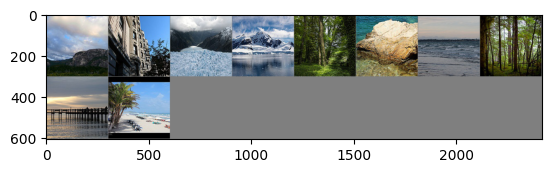

labels :  tensor([3, 0, 2, 3, 1, 4, 4, 1, 4, 4], device='cuda:0')

values :  tensor([6.4995, 7.1287, 8.7903, 5.8099, 6.4097, 4.4794, 4.3782, 9.9653, 4.6089,
        2.3839], device='cuda:0')

predicted label :  tensor([3, 0, 2, 2, 1, 4, 4, 1, 4, 5], device='cuda:0')

Accuracy :  8.0
[  2 /  20] train loss : 3.663, validation accuracy : 88.600
 Saving model!!! 

Duration (seconds) : 503.47237277030945
Duration (minutes) : 8.391206359863281
Duration (hours) : 0.13985344052314758


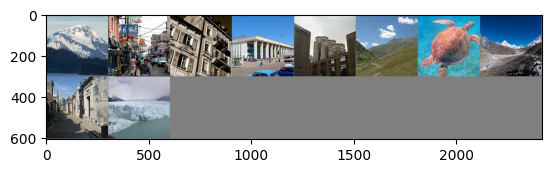

labels :  tensor([2, 5, 0, 0, 0, 3, 4, 3, 5, 2], device='cuda:0')

values :  tensor([4.0814, 7.1211, 4.6418, 3.5835, 7.2671, 6.8967, 8.5610, 7.6970, 5.4684,
        7.8272], device='cuda:0')

predicted label :  tensor([3, 5, 0, 0, 0, 3, 4, 2, 5, 2], device='cuda:0')

Accuracy :  8.0
[  3 /  20] train loss : 2.722, validation accuracy : 89.200
 Saving model!!! 

Duration (seconds) : 503.49509859085083
Duration (minutes) : 8.391585143407186
Duration (hours) : 0.13985975371466744


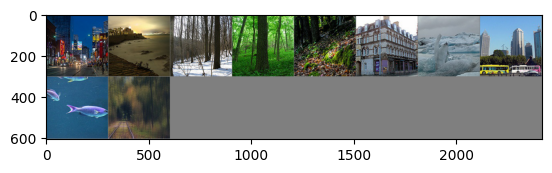

labels :  tensor([5, 4, 1, 1, 1, 0, 2, 0, 4, 1], device='cuda:0')

values :  tensor([ 9.0337,  6.5178,  9.3056,  6.2754,  7.4157,  6.3711,  8.8286, 11.2232,
         2.7714,  2.1784], device='cuda:0')

predicted label :  tensor([5, 4, 1, 1, 1, 0, 2, 0, 2, 5], device='cuda:0')

Accuracy :  8.0
[  4 /  20] train loss : 1.978, validation accuracy : 89.533
 Saving model!!! 

Duration (seconds) : 503.39064860343933
Duration (minutes) : 8.389844290415446
Duration (hours) : 0.13983073943191104


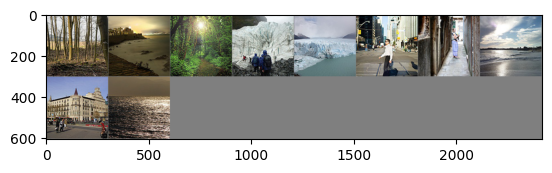

labels :  tensor([1, 4, 1, 2, 2, 5, 5, 4, 0, 4], device='cuda:0')

values :  tensor([9.8458, 6.1995, 7.1612, 5.7398, 8.0829, 8.8449, 9.1360, 8.1237, 7.0186,
        8.7929], device='cuda:0')

predicted label :  tensor([1, 4, 1, 2, 2, 5, 5, 4, 0, 4], device='cuda:0')

Accuracy :  10.0
[  5 /  20] train loss : 1.551, validation accuracy : 90.233
 Saving model!!! 

Duration (seconds) : 503.54813051223755
Duration (minutes) : 8.392469028631846
Duration (hours) : 0.13987448539998795


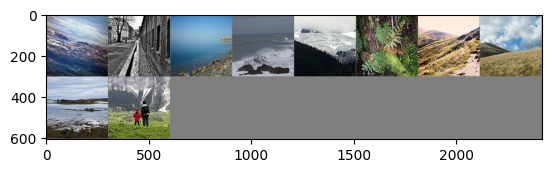

labels :  tensor([3, 5, 4, 4, 2, 1, 3, 3, 4, 3], device='cuda:0')

values :  tensor([ 5.5931, 11.6147,  9.4098,  7.8194,  8.1066,  8.4067,  4.4773,  8.2541,
         6.9797,  5.1696], device='cuda:0')

predicted label :  tensor([3, 5, 4, 4, 2, 1, 2, 3, 4, 1], device='cuda:0')

Accuracy :  8.0
[  6 /  20] train loss : 1.449, validation accuracy : 90.533
 Saving model!!! 

Duration (seconds) : 503.6350564956665
Duration (minutes) : 8.39391777118047
Duration (hours) : 0.13989863071176742


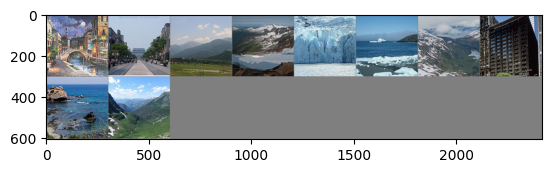

labels :  tensor([5, 5, 3, 3, 2, 4, 2, 0, 4, 2], device='cuda:0')

values :  tensor([ 6.1792, 10.2018,  8.5020,  8.1959,  7.8719,  6.6966,  4.9674,  9.6182,
        11.0604,  6.8715], device='cuda:0')

predicted label :  tensor([0, 5, 3, 2, 2, 4, 2, 0, 4, 3], device='cuda:0')

Accuracy :  7.0
[  7 /  20] train loss : 1.118, validation accuracy : 90.700
 Saving model!!! 

Duration (seconds) : 503.80091881752014
Duration (minutes) : 8.39668213526408
Duration (hours) : 0.13994470338026682


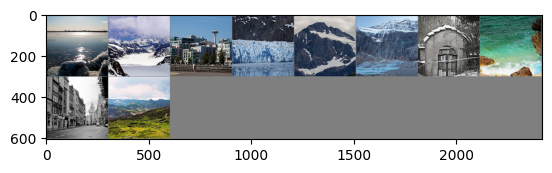

labels :  tensor([4, 2, 0, 2, 2, 2, 0, 4, 5, 3], device='cuda:0')

values :  tensor([ 9.1481,  6.2553,  5.5528,  7.7907,  5.1942,  5.5961,  6.9371,  9.0264,
        12.1708,  8.3345], device='cuda:0')

predicted label :  tensor([4, 3, 5, 2, 2, 2, 0, 4, 5, 3], device='cuda:0')

Accuracy :  8.0
[  8 /  20] train loss : 1.059, validation accuracy : 90.167
Duration (seconds) : 503.5115177631378
Duration (minutes) : 8.391858716805777
Duration (hours) : 0.13986431274149153


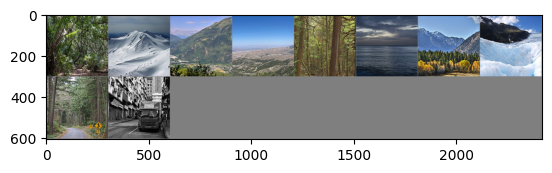

labels :  tensor([1, 3, 2, 3, 1, 4, 3, 2, 1, 5], device='cuda:0')

values :  tensor([ 7.0385,  4.9211,  9.9902,  7.0507,  7.9727,  8.6517,  8.3956,  8.3492,
         7.7264, 14.7704], device='cuda:0')

predicted label :  tensor([1, 2, 3, 3, 1, 4, 3, 2, 1, 5], device='cuda:0')

Accuracy :  8.0
[  9 /  20] train loss : 1.130, validation accuracy : 90.167
Duration (seconds) : 503.26503586769104
Duration (minutes) : 8.387750713030497
Duration (hours) : 0.1397958462105857


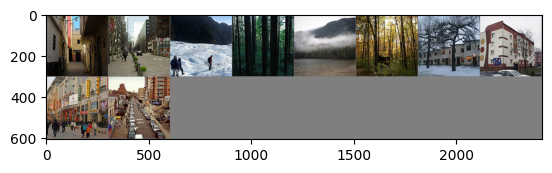

labels :  tensor([5, 5, 2, 1, 3, 1, 0, 0, 5, 5], device='cuda:0')

values :  tensor([ 8.3933,  9.0264, 10.9615, 10.8824,  7.2723, 13.9758,  6.7256,  8.6129,
         7.7182,  7.0698], device='cuda:0')

predicted label :  tensor([5, 5, 2, 1, 4, 1, 0, 0, 5, 5], device='cuda:0')

Accuracy :  9.0
[ 10 /  20] train loss : 0.817, validation accuracy : 90.733
 Saving model!!! 

Duration (seconds) : 503.2700295448303
Duration (minutes) : 8.387833976745606
Duration (hours) : 0.13979723407162561


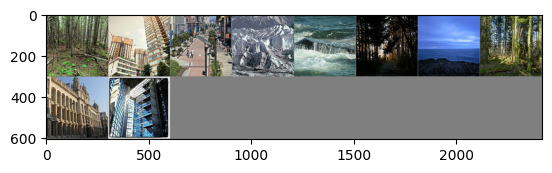

labels :  tensor([1, 0, 5, 2, 4, 1, 4, 1, 0, 0], device='cuda:0')

values :  tensor([11.2919, 10.7308, 11.0549,  9.6297,  8.7666, 10.7325, 12.1518, 10.0649,
         6.4230,  8.2162], device='cuda:0')

predicted label :  tensor([1, 0, 5, 2, 4, 1, 4, 1, 0, 0], device='cuda:0')

Accuracy :  10.0
[ 11 /  20] train loss : 0.833, validation accuracy : 91.200
 Saving model!!! 

Duration (seconds) : 503.2391276359558
Duration (minutes) : 8.387318921089172
Duration (hours) : 0.1397886496120029


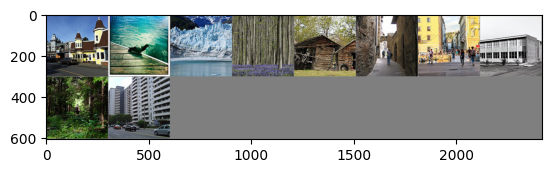

labels :  tensor([0, 4, 2, 1, 0, 5, 5, 0, 1, 0], device='cuda:0')

values :  tensor([ 5.7595,  7.2026, 11.2433, 13.1365,  6.4176, 12.1539,  9.4975,  8.7281,
        12.3340,  8.3226], device='cuda:0')

predicted label :  tensor([5, 4, 2, 1, 0, 5, 5, 0, 1, 0], device='cuda:0')

Accuracy :  9.0
[ 12 /  20] train loss : 0.809, validation accuracy : 90.567
Duration (seconds) : 503.30472207069397
Duration (minutes) : 8.388412125905354
Duration (hours) : 0.13980686955981783


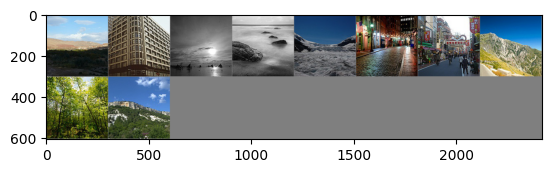

labels :  tensor([3, 0, 4, 4, 2, 5, 5, 3, 1, 3], device='cuda:0')

values :  tensor([ 6.6242, 11.7505,  7.3744, 11.1582,  9.7757,  9.2508, 10.4488, 10.4788,
        12.7762,  6.9605], device='cuda:0')

predicted label :  tensor([3, 0, 4, 4, 2, 5, 5, 3, 1, 3], device='cuda:0')

Accuracy :  10.0
[ 13 /  20] train loss : 0.803, validation accuracy : 90.600
Duration (seconds) : 503.4546477794647
Duration (minutes) : 8.390910879770916
Duration (hours) : 0.1398485153913498


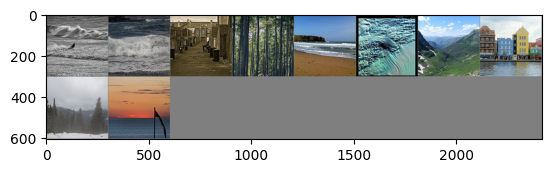

labels :  tensor([4, 4, 5, 1, 4, 2, 2, 0, 3, 4], device='cuda:0')

values :  tensor([ 6.2335,  5.6910,  9.1887,  9.5989,  7.8909,  3.0755,  7.1770, 10.8289,
         8.2151,  8.7619], device='cuda:0')

predicted label :  tensor([4, 4, 5, 1, 4, 0, 3, 0, 3, 4], device='cuda:0')

Accuracy :  8.0
[ 14 /  20] train loss : 0.689, validation accuracy : 91.200
Duration (seconds) : 508.64786028862
Duration (minutes) : 8.477464425563813
Duration (hours) : 0.14129107455412546


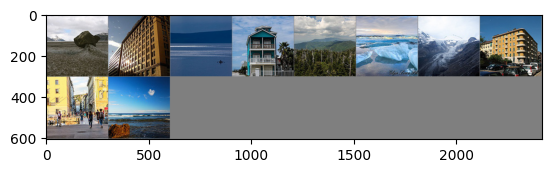

labels :  tensor([2, 0, 4, 0, 3, 2, 2, 0, 5, 4], device='cuda:0')

values :  tensor([ 4.4162,  8.6779,  8.8704, 11.3290,  8.8445,  7.7888,  8.1284,  7.0786,
        11.2872, 12.5384], device='cuda:0')

predicted label :  tensor([3, 0, 4, 0, 3, 2, 2, 0, 5, 4], device='cuda:0')

Accuracy :  9.0
[ 15 /  20] train loss : 0.778, validation accuracy : 91.267
 Saving model!!! 

Duration (seconds) : 508.96348786354065
Duration (minutes) : 8.48272490898768
Duration (hours) : 0.14137874927785662


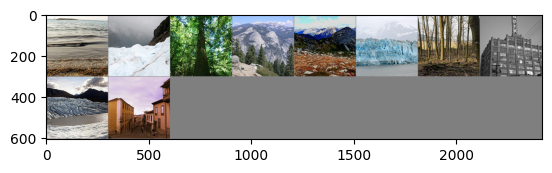

labels :  tensor([4, 2, 1, 2, 3, 2, 1, 0, 2, 5], device='cuda:0')

values :  tensor([ 9.9136,  8.5414, 13.0190, 11.2736, 11.2015,  9.0600, 14.5342, 13.4646,
         5.5031,  6.7237], device='cuda:0')

predicted label :  tensor([4, 2, 1, 3, 3, 2, 1, 0, 2, 0], device='cuda:0')

Accuracy :  8.0
[ 16 /  20] train loss : 0.668, validation accuracy : 90.800
Duration (seconds) : 503.0414092540741
Duration (minutes) : 8.384023571014405
Duration (hours) : 0.1397337269120746


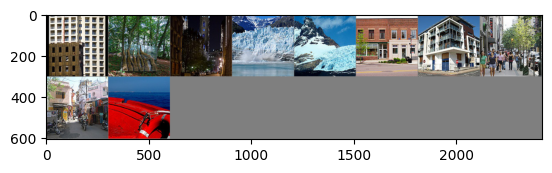

labels :  tensor([0, 1, 5, 2, 2, 0, 0, 5, 5, 4], device='cuda:0')

values :  tensor([ 9.4350, 10.2332,  4.3394, 14.2718, 10.5783,  8.2492, 11.9325, 13.3312,
         7.8924,  4.8080], device='cuda:0')

predicted label :  tensor([0, 1, 1, 2, 2, 0, 0, 5, 5, 4], device='cuda:0')

Accuracy :  9.0
[ 17 /  20] train loss : 0.696, validation accuracy : 91.233
Duration (seconds) : 502.9973249435425
Duration (minutes) : 8.383288828531901
Duration (hours) : 0.1397214812702603


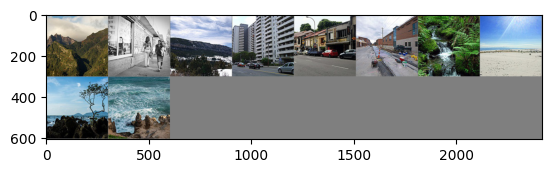

labels :  tensor([3, 5, 3, 0, 5, 5, 1, 2, 4, 4], device='cuda:0')

values :  tensor([11.3576, 11.1441,  9.3811, 12.0397, 11.2397, 11.0484, 14.0020,  7.9749,
         9.9273,  8.7271], device='cuda:0')

predicted label :  tensor([3, 5, 3, 0, 5, 5, 1, 4, 4, 4], device='cuda:0')

Accuracy :  9.0
[ 18 /  20] train loss : 0.576, validation accuracy : 90.833
Duration (seconds) : 503.240647315979
Duration (minutes) : 8.387344197432201
Duration (hours) : 0.13978907075193192


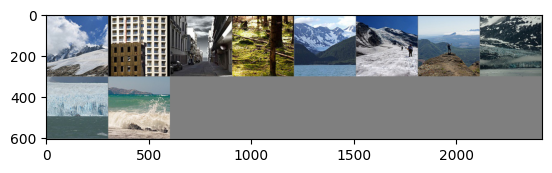

labels :  tensor([2, 0, 5, 1, 2, 2, 3, 2, 2, 4], device='cuda:0')

values :  tensor([ 6.2520, 15.0520, 14.9950, 16.1207,  5.4080,  7.1152,  8.0660,  6.6848,
         9.8744, 11.0975], device='cuda:0')

predicted label :  tensor([3, 0, 5, 1, 2, 2, 3, 2, 2, 4], device='cuda:0')

Accuracy :  9.0
[ 19 /  20] train loss : 0.649, validation accuracy : 90.433
Duration (seconds) : 503.1331899166107
Duration (minutes) : 8.385553248723348
Duration (hours) : 0.1397592216067844


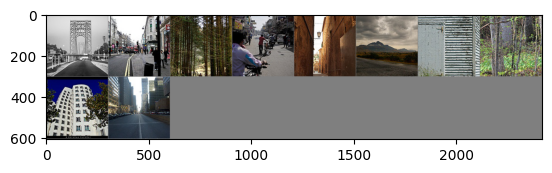

labels :  tensor([5, 5, 1, 5, 5, 3, 0, 1, 0, 5], device='cuda:0')

values :  tensor([ 9.3423,  8.5828, 10.6944,  7.5980, 10.2206, 11.6945,  4.8320,  7.7307,
         7.8949,  7.5281], device='cuda:0')

predicted label :  tensor([5, 5, 1, 5, 5, 3, 4, 1, 0, 5], device='cuda:0')

Accuracy :  9.0
[ 20 /  20] train loss : 0.621, validation accuracy : 91.733
 Saving model!!! 

Duration (seconds) : 503.3694567680359
Duration (minutes) : 8.389491120974222
Duration (hours) : 0.1398248533407847


In [15]:
train(model, 20)

## Best model load(저장된 모델 불러와서 사용하기)
- Removing correct image under 1.5 and wrong image over 1.5 (accuracy)

- ref method : https://medium.com/@afzalsayed96/1st-place-solution-for-intel-scene-classification-challenge-c95cf941f8ed


In [62]:
from torch.utils.data import DataLoader

# batch없이 load
tmp_trainloader = DataLoader(MyDataset(trainset_path, classes, MyTransform(img_size)), batch_size = 12, shuffle=False)
print("The number of images in a training set : ", len(tmp_trainloader)*12)

The number of images in a training set :  14040


In [64]:
saved_model = timm.create_model('resnet50d', pretrained = True, num_classes = len(classes), global_pool = 'catavgmax')
saved_model.fc = nn.Sequential(
    nn.BatchNorm1d(num_in_features),
    nn.Linear(in_features = num_in_features, out_features = 512, bias = True),
    nn.ReLU(),
    nn.BatchNorm1d(512),
    nn.Dropout(dropout),
    nn.Linear(in_features = 512, out_features = 6, bias = True))

saved_model.load_state_dict(torch.load('./timm_result/timm_sceneClassModel_2.pth'))
# saved_model.eval()

for params in saved_model.state_dict():
    print(params, " : ", saved_model.state_dict()[params].size())

conv1.0.weight  :  torch.Size([32, 3, 3, 3])
conv1.1.weight  :  torch.Size([32])
conv1.1.bias  :  torch.Size([32])
conv1.1.running_mean  :  torch.Size([32])
conv1.1.running_var  :  torch.Size([32])
conv1.1.num_batches_tracked  :  torch.Size([])
conv1.3.weight  :  torch.Size([32, 32, 3, 3])
conv1.4.weight  :  torch.Size([32])
conv1.4.bias  :  torch.Size([32])
conv1.4.running_mean  :  torch.Size([32])
conv1.4.running_var  :  torch.Size([32])
conv1.4.num_batches_tracked  :  torch.Size([])
conv1.6.weight  :  torch.Size([64, 32, 3, 3])
bn1.weight  :  torch.Size([64])
bn1.bias  :  torch.Size([64])
bn1.running_mean  :  torch.Size([64])
bn1.running_var  :  torch.Size([64])
bn1.num_batches_tracked  :  torch.Size([])
layer1.0.conv1.weight  :  torch.Size([64, 64, 1, 1])
layer1.0.bn1.weight  :  torch.Size([64])
layer1.0.bn1.bias  :  torch.Size([64])
layer1.0.bn1.running_mean  :  torch.Size([64])
layer1.0.bn1.running_var  :  torch.Size([64])
layer1.0.bn1.num_batches_tracked  :  torch.Size([])
layer

In [65]:
i = 0

for images, labels in tmp_trainloader:
    if i==0:
        print(images.size(), end="\n\n")
        print(labels, end="\n\n")
        outputs = saved_model(images)
        print(outputs, end="\n\n")
        value = torch.max(outputs, 1)
        print(value[0], end="\n\n")
        print(value[1], end="\n\n")
        
        i+=1
    else:
        break

torch.Size([12, 3, 300, 300])

tensor([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0])

tensor([[-2.8825,  2.3388,  2.4872,  3.6754, -4.1663, -2.5318],
        [ 0.5233, -1.2905, -1.9759, -0.7303,  3.4664,  0.9068],
        [ 1.4897,  0.5188, -3.4003, -0.9172,  2.2105,  1.5228],
        [-2.2030,  0.8469,  3.0552, -0.0477,  3.8588, -6.8050],
        [-0.8512, -3.0505,  3.0657,  3.5016, -1.2809, -4.5159],
        [-7.6096,  3.9684,  3.1273,  6.1046,  1.6317, -8.1721],
        [-6.4417, -3.2085,  5.3494,  3.6997, -2.2171, -1.1150],
        [ 0.1707, -3.1661, -1.9432, -1.1628,  0.3533,  5.8225],
        [ 7.3839,  1.3136, -1.5074, -5.9318, -0.7173,  0.5041],
        [ 1.2424, -2.0189,  4.6069, -4.3283, -0.4662,  0.2988],
        [ 4.9640, -3.9674, -2.4193, -1.4312, -3.2829,  4.9846],
        [ 1.7489,  0.3803, -2.1353,  1.3062, -2.1456,  1.6218]],
       grad_fn=<AddmmBackward0>)

tensor([3.6754, 3.4664, 2.2105, 3.8588, 3.5016, 6.1046, 5.3494, 5.8225, 7.3839,
        4.6069, 4.9846, 1.7489], grad_fn

In [38]:
def rm_image(model):
    
    trainpath_cp = trainset_path
    rm_indices = []
    
    with torch.no_grad():
        
        for i, (images, labels) in enumerate(tmp_trainloader,0):
            
            outputs = saved_model(images)
            
            value[0] = torch.max(outputs, 1)
              
            if value < 0.55 or value > 0.999:
                rm_indices.append(i)
                
            i += 1
             
    for idx in sorted(rm_indices, reverse=True):
        del trainpath_cp[idx]
    
    return trainpath_cp

In [39]:
trainset_path_f = rm_image(model)
print("after removing low accuracy image, there are ", len(trainset_path_f), " images left.")

ValueError: Expected more than 1 value per channel when training, got input size torch.Size([1, 4096])